In [ ]:
import sys
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
from pypalettes import load_cmap
import numpy as np
import os
from pycocotools.coco import COCO
import tqdm
from pycocotools import mask as coco_mask

project_root = Path().resolve().parent 
sys.path.append(str(project_root))

from src.config import ANNOTATIONS_DIR, FIGURES_DIR, RAW_DATA_DIR

In [131]:
file_path = ANNOTATIONS_DIR / "info_test2020.json"
with open(file_path, "r") as file:
    data = json.load(file)

main_item_names = [category["name"] for category in data["categories"]]

def decode_rle_mask(rle, height, width):
    """
    Decode RLE encoded mask to binary mask.
    """
    return coco_mask.decode(rle)


def create_segmentation_mask(coco, img_id, height, width, mappings):
    """
    Create segmentation mask from COCO annotations.
    """
    # Initialize empty mask with zeros (background)
    mask = np.zeros((height, width), dtype=np.uint8)

    # Get annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    print(len(ann_ids))
    anns = coco.loadAnns(ann_ids)
    print(len(anns))

    masks_with_cats = []

    for ann in anns:
        cat_id = ann["category_id"]
        # Skip if not in main categories
        # if cat_id not in mappings["orig_id_to_new_id"]:
        #     continue

        new_cat_id = mappings["orig_id_to_new_id"][cat_id]
        seg = ann.get("segmentation")
        if seg is None:
            continue

        # Decode segmentation mask based on its type
        if isinstance(seg, dict):  # RLE format
            binary_mask = decode_rle_mask(seg, height, width)
        elif isinstance(seg, list):  # Polygon format
            binary_mask = coco.annToMask(ann)
        else:
            continue

        area = ann.get("area", np.sum(binary_mask))
        masks_with_cats.append((binary_mask, new_cat_id, area))

    # Sort by area (ascending) so smaller objects overlay larger ones
    masks_with_cats.sort(key=lambda x: x[2])

    # Update mask in place to avoid extra memory allocation
    for binary_mask, category_id, _ in masks_with_cats:
        mask[binary_mask == 1] = category_id  # in-place assignment

    return mask


def load_fashionpedia_categories(ann_file):
    """
    Load Fashionpedia categories and create id mappings for our main garments.
    """
    with open(ann_file, "r") as f:
        dataset = json.load(f)

    categories = dataset["categories"]

    # Use dictionary comprehensions for more concise mapping creation
    orig_id_to_name = {cat["id"]: cat["name"] for cat in categories}
    name_to_orig_id = {cat["name"]: cat["id"] for cat in categories}

    # Get main category ids from our target list
    main_category_ids = [
        name_to_orig_id[name] for name in main_item_names if name in name_to_orig_id
    ]

    # Create our own consecutive ids for the categories, with 0 as background
    id_to_name = {0: "background"}
    name_to_id = {"background": 0}
    orig_id_to_new_id = {}

    for i, name in enumerate(main_item_names):
        new_id = i + 1  # Reserve 0 for background
        id_to_name[new_id] = name
        name_to_id[name] = new_id
        if name in name_to_orig_id:
            orig_id_to_new_id[name_to_orig_id[name]] = new_id

    num_classes = len(main_item_names) + 1  # Including background

    return {
        "orig_id_to_name": orig_id_to_name,
        "name_to_orig_id": name_to_orig_id,
        "id_to_name": id_to_name,
        "name_to_id": name_to_id,
        "orig_id_to_new_id": orig_id_to_new_id,
        "main_category_ids": main_category_ids,
        "num_classes": num_classes,
    }


def setup_fashionpedia(data_dir):
    """
    Setup paths for Fashionpedia dataset.
    """
    train_img_dir = os.path.join(data_dir, "images", "train")
    val_img_dir = os.path.join(data_dir, "images", "test")

    train_ann_file = os.path.join(
        data_dir, "annotations", "instances_attributes_train2020.json"
    )
    val_ann_file = os.path.join(
        data_dir, "annotations", "instances_attributes_val2020.json"
    )

    # Verify paths exist
    for path in [train_img_dir, val_img_dir, train_ann_file, val_ann_file]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Path does not exist: {path}")

    return {
        "train_img_dir": train_img_dir,
        "val_img_dir": val_img_dir,
        "train_ann_file": train_ann_file,
        "val_ann_file": val_ann_file,
    }

In [ ]:
def compute_segmentation_statistics(coco, img_dir, ann_file, category_mappings, split):
    image_data = []

    img_ids = coco.getImgIds()
    for img_id in tqdm.tqdm(img_ids, desc=f"Processing {split} images"):
        img_info = coco.loadImgs([img_id])[0]
        width, height = img_info["width"], img_info["height"]
        image_pixels = width * height

        mask = create_segmentation_mask(coco, img_id, height, width, category_mappings)
        foreground_pixels = np.count_nonzero(mask)
        unique_categories = np.unique(mask)
        for cat_id in unique_categories:
            if cat_id == 0:
                continue
            category_name = category_mappings["id_to_name"].get(cat_id, "Unknown")
            category_pixels = np.count_nonzero(mask == cat_id)

            fg_area_ratio = (
                category_pixels / foreground_pixels if foreground_pixels > 0 else 0
            )
            total_area_ratio = category_pixels / image_pixels if image_pixels > 0 else 0

            image_data.append(
                {
                    "image_id": img_id,
                    "image_label": split,
                    "category_id": cat_id,
                    "category_name": category_name,
                    "category_pixels": category_pixels,
                    "foreground_pixels": foreground_pixels,
                    "image_pixels": image_pixels,
                    "fg_area_ratio": fg_area_ratio,
                    "total_area_ratio": total_area_ratio,
                }
            )

    return pd.DataFrame(image_data)


data_paths = setup_fashionpedia(RAW_DATA_DIR)
category_mappings = load_fashionpedia_categories(data_paths["train_ann_file"])

train_coco = COCO(data_paths["train_ann_file"])
val_coco = COCO(data_paths["val_ann_file"])

train_df = compute_segmentation_statistics(
    train_coco,
    data_paths["train_img_dir"],
    data_paths["train_ann_file"],
    category_mappings,
    "train",
)
val_df = compute_segmentation_statistics(
    val_coco,
    data_paths["val_img_dir"],
    data_paths["val_ann_file"],
    category_mappings,
    "test",
)

dataset_df = pd.concat([train_df, val_df], ignore_index=True)

dataset_df

In [126]:
x = dataset_df[dataset_df["image_id"]==16305]

x

,image_id,image_label,category_id,category_name,category_pixels,foreground_pixels,image_pixels,fg_area_ratio,total_area_ratio
3381,16305,train,1,"shirt, blouse",78456,91751,696320,0.855097,0.112672
3382,16305,train,23,sock,13253,91751,696320,0.144445,0.019033
3383,16305,train,29,collar,2,91751,696320,0.000022,0.000003
3384,16305,train,32,sleeve,40,91751,696320,0.000436,0.000057


## Counting the number of images per label

In [110]:
count_df = (
    dataset_df.groupby(["category_id", "category_name"])["image_id"]
    .apply(list)
    .reset_index(name="occurrence")
)

count_df["image_count"] = count_df["occurrence"].apply(len)

count_df["label_count"] = count_df["occurrence"].apply(lambda x: len(set(x)))

count_df

,category_id,category_name,occurrence,image_count,label_count
0,1,"shirt, blouse","[17264, 17672, 9459, 16375, 9661, 16113, 20165...",6217,6217
1,2,"top, t-shirt, sweatshirt","[12446, 17107, 9459, 9446, 13028, 16265, 19980...",16632,16632
2,3,sweater,"[12069, 19711, 17338, 12970, 10830, 10723, 169...",1506,1506
3,4,cardigan,"[18278, 14772, 17513, 12748, 15584, 13227, 166...",1113,1113
4,5,jacket,"[17672, 9459, 9446, 13028, 9661, 15671, 10431,...",7921,7921
5,6,vest,"[9614, 16353, 10853, 13405, 20372, 20201, 8852...",738,738
6,7,pants,"[19069, 16584, 19458, 9531, 9979, 12666, 12989...",12660,12660
7,8,shorts,"[16145, 20561, 13389, 9520, 16271, 20201, 1632...",2851,2851
8,9,skirt,"[11667, 18291, 12624, 17307, 16278, 19640, 934...",5196,5196
9,10,coat,"[17264, 10359, 12666, 17361, 12989, 11397, 195...",3188,3188


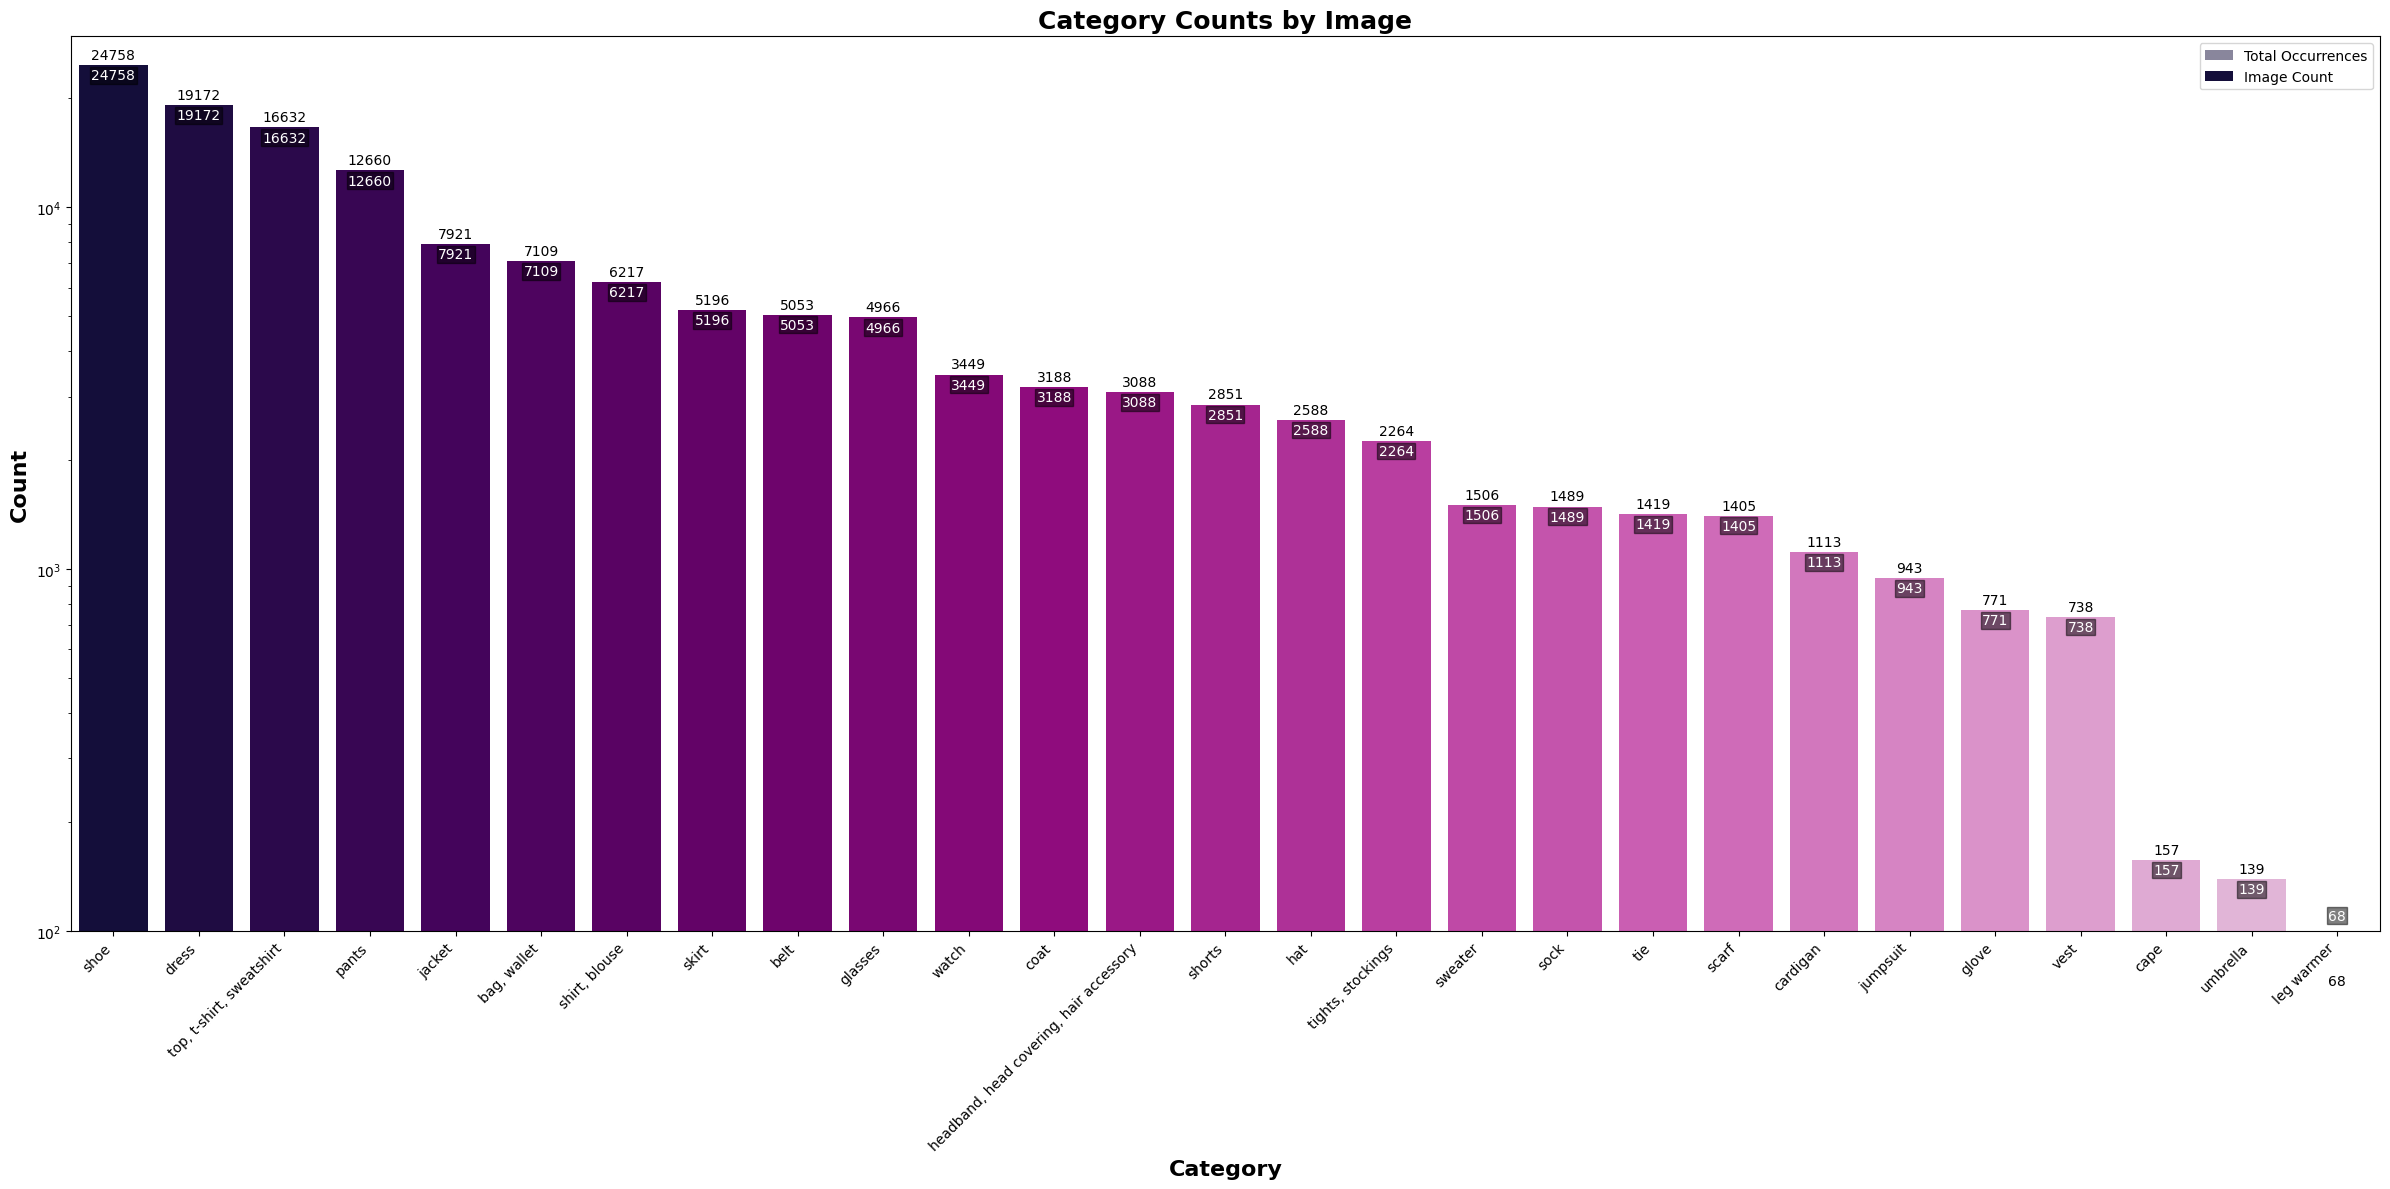

In [111]:
cmap = load_cmap("Flash", cmap_type="continuous", reverse=True)

num_categories = len(count_df)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

sorted_stats = count_df.sort_values("label_count", ascending=False)

plt.figure(figsize=(24, 12))  

plt.ylim(100, sorted_stats["label_count"].max() * 1.2)

bars1 = plt.bar(
    range(len(sorted_stats)),
    sorted_stats["label_count"],
    alpha=0.5,
    color=colors,
    label="Total Occurrences",
)

bars2 = plt.bar(
    range(len(sorted_stats)),
    sorted_stats["image_count"],
    color=colors,
    label="Image Count",
)

plt.xticks(
    range(len(sorted_stats)), sorted_stats["category_name"], rotation=45, ha="right"
)

plt.xlabel("Category", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold")
plt.title("Category Counts by Image", fontsize=18, fontweight="bold")

plt.yscale("log")
plt.xlim(-0.5, len(sorted_stats) - 0.5)

# Add count labels on top of bars
for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height * 1.02,  # Slightly above the bar
        f"{int(height)}",
        ha="center",
        va="bottom",
    )

for bar in bars2:
    height = bar.get_height()
    label_y_position = max(height * 0.98, 115)  # Ensure labels don't drop below 115

    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        label_y_position,
        f"{int(height)}",
        ha="center",
        va="top",
        color="white",
        bbox=dict(facecolor="black", alpha=0.5, pad=1),
    )

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_counts_by_image.png")
plt.show()


## Mean and Variance for the Pixel Ratio per Category

In [228]:
def get_non_foreground_area(df):
    return df.groupby("image_id")["area"].sum()

area_df = instance_df[
    ["image_id", "category_id", "category_name", "bbox", "area", "total_area"]
].copy()

area_df["foreground_area"] = np.maximum(0, area_df["total_area"] - area_df["image_id"].map(get_non_foreground_area(area_df)))


area_df["area_ratio"] = (
    area_df["area"] / area_df["total_area"]
)  
area_df["foreground_area_ratio"] = np.minimum(1, (
    area_df["area"] / area_df["foreground_area"]
))

area_df

,image_id,category_id,category_name,bbox,area,total_area,foreground_area,area_ratio,foreground_area_ratio
0,16305,32,pocket,"[454.0, 390.0, 46.0, 109.0]",3052,696320,581805,0.004383,0.005246
1,16305,31,sleeve,"[271.0, 133.0, 98.0, 223.0]",12906,696320,581805,0.018535,0.022183
2,16305,31,sleeve,"[482.0, 323.0, 74.0, 169.0]",5794,696320,581805,0.008321,0.009959
3,16305,22,sock,"[322.0, 658.0, 208.0, 112.0]",3838,696320,581805,0.005512,0.006597
4,16305,22,sock,"[405.0, 749.0, 97.0, 213.0]",9415,696320,581805,0.013521,0.016182
...,...,...,...,...,...,...,...,...,...
8776,13599,8,skirt,"[439.0, 406.0, 233.0, 523.0]",62602,925696,780986,0.067627,0.080158
8777,13599,23,shoe,"[616.0, 901.0, 50.0, 80.0]",1531,925696,780986,0.001654,0.001960
8778,13599,23,shoe,"[596.0, 880.0, 15.0, 37.0]",248,925696,780986,0.000268,0.000318
8779,13599,31,sleeve,"[561.0, 202.0, 109.0, 304.0]",10809,925696,780986,0.011677,0.013840


In [113]:
ratio_df = (
    dataset_df.groupby(["category_id", "category_name"])
    .agg(
        area_ratio_mean=("total_area_ratio", "mean"),
        area_ratio_median=("total_area_ratio", "median"),
        area_ratio_stdev=("total_area_ratio", "std"),
        foreground_area_ratio_mean=("fg_area_ratio", "mean"),
        foreground_area_ratio_median=("fg_area_ratio", "median"),
        foreground_area_ratio_stdev=("fg_area_ratio", "std"),
    )
    .reset_index()
)

ratio_df


,category_id,category_name,area_ratio_mean,area_ratio_median,area_ratio_stdev,foreground_area_ratio_mean,foreground_area_ratio_median,foreground_area_ratio_stdev
0,1,"shirt, blouse",0.093785,0.036582,0.141097,0.345651,0.210855,0.332753
1,2,"top, t-shirt, sweatshirt",0.109499,0.046636,0.150507,0.433769,0.359772,0.327271
2,3,sweater,0.218605,0.130477,0.207119,0.627690,0.645068,0.343440
3,4,cardigan,0.165487,0.075877,0.198622,0.516330,0.443678,0.295494
4,5,jacket,0.134990,0.084521,0.132507,0.540898,0.512481,0.218057
5,6,vest,0.068118,0.037040,0.097669,0.307380,0.261782,0.253362
6,7,pants,0.071287,0.060314,0.068463,0.371535,0.352236,0.185273
7,8,shorts,0.049709,0.024599,0.094360,0.284902,0.241770,0.215763
8,9,skirt,0.087049,0.060714,0.095339,0.477269,0.465169,0.224928
9,10,coat,0.165029,0.114915,0.144890,0.645678,0.637652,0.217087


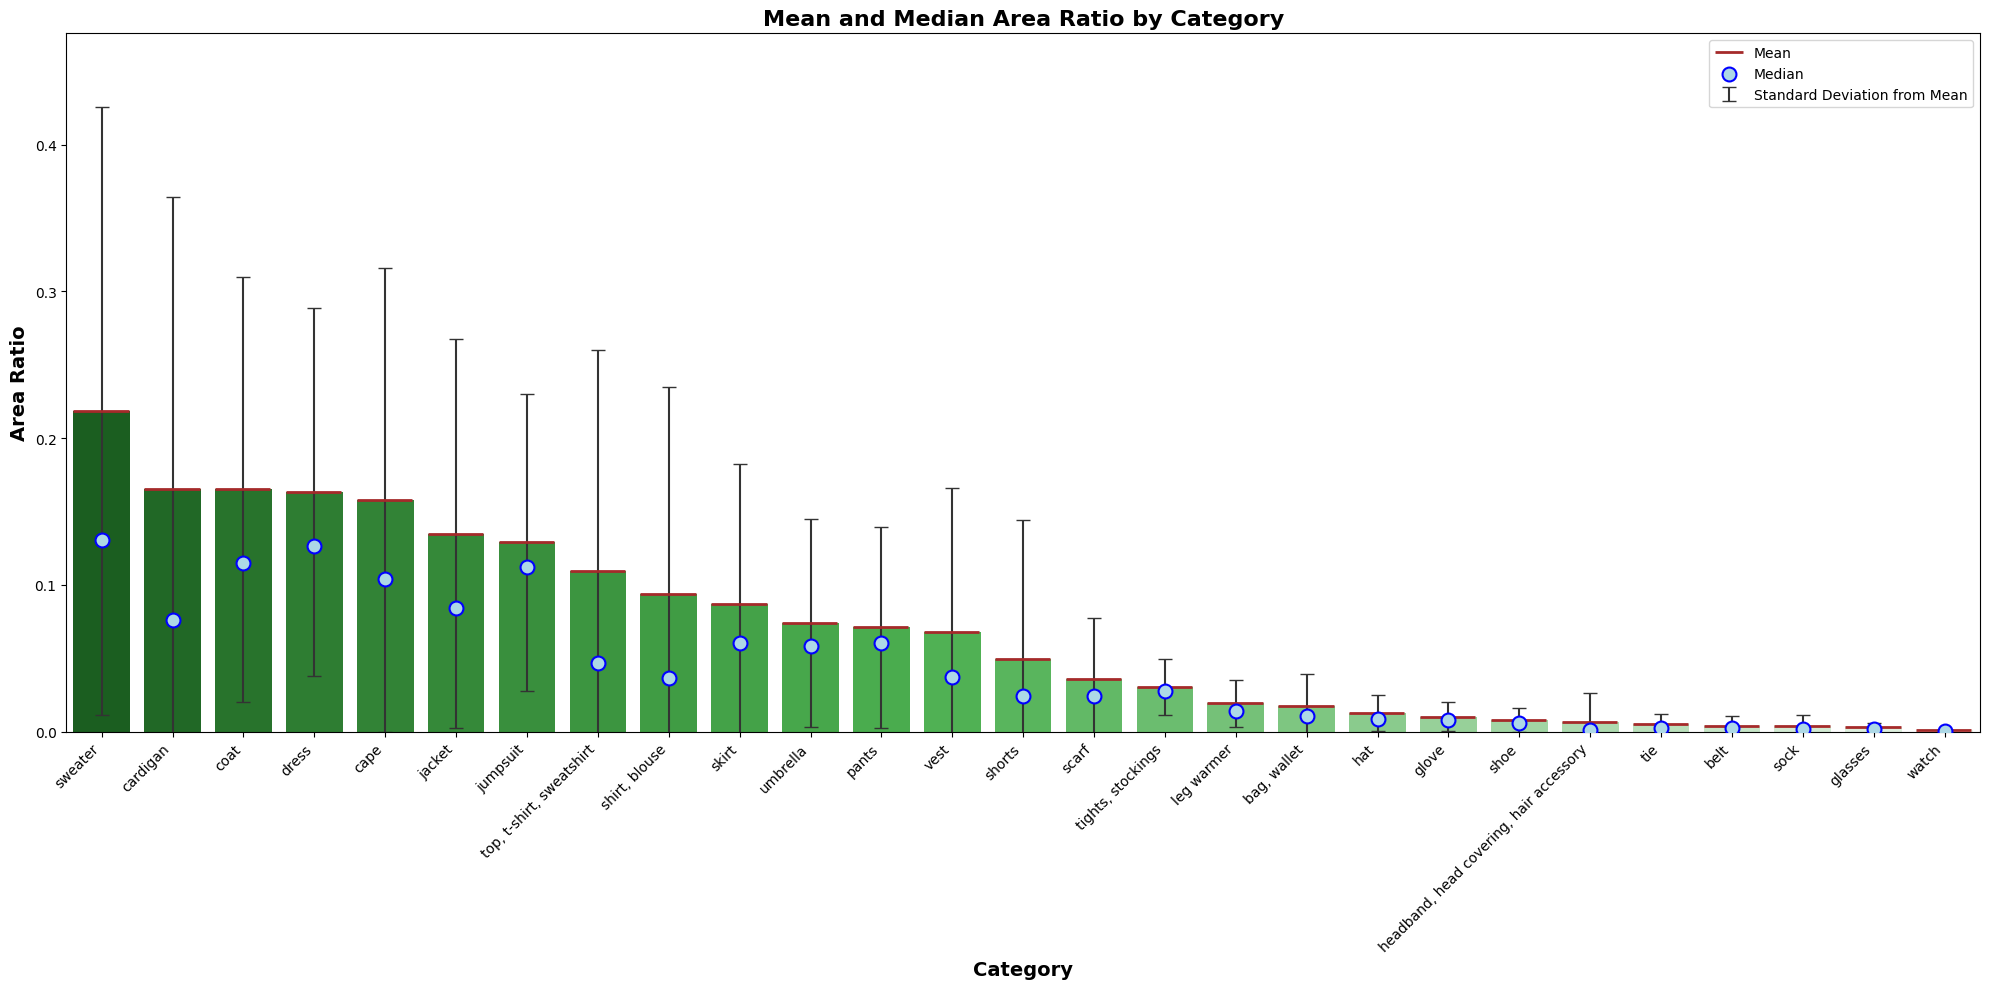

In [121]:
sorted_stats = ratio_df.sort_values("area_ratio_mean", ascending=False)

cmap = load_cmap("green_material", cmap_type="continuous", reverse=True)

num_categories = len(sorted_stats)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

plt.figure(figsize=(20, 10))

bar_width = 0.8  
x_positions = np.arange(len(sorted_stats))

plt.bar(x_positions, sorted_stats["area_ratio_mean"], color=colors, width=bar_width)

plt.errorbar(
    x_positions,
    sorted_stats["area_ratio_mean"],
    yerr=sorted_stats["area_ratio_stdev"],
    ecolor="#333333",
    capsize=5,
    fmt="none",
    label="Standard Deviation from Mean",
)

plt.hlines(
    y=sorted_stats["area_ratio_mean"],
    xmin=x_positions - 0.4,
    xmax=x_positions + 0.38,
    colors="brown",
    linewidth=2,
    label="Mean",
    zorder=3,
)

plt.xticks(x_positions, sorted_stats["category_name"], rotation=45, ha="right")

plt.xlim(-0.5, len(sorted_stats) - 0.5) 

plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Area Ratio", fontsize=14, fontweight="bold")
plt.title("Mean and Median Area Ratio by Category", fontsize=16, fontweight="bold")

plt.scatter(
    x_positions,
    sorted_stats["area_ratio_median"],
    marker="o",
    color="lightblue",
    edgecolor="blue",
    linewidth=1.5,
    s=100,
    zorder=4,
    label="Median",
)

upper_limit = (
    sorted_stats["area_ratio_mean"] + sorted_stats["area_ratio_stdev"]
).max() + 0.05
plt.ylim(0, upper_limit)

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_area_ratio.png")
plt.show()

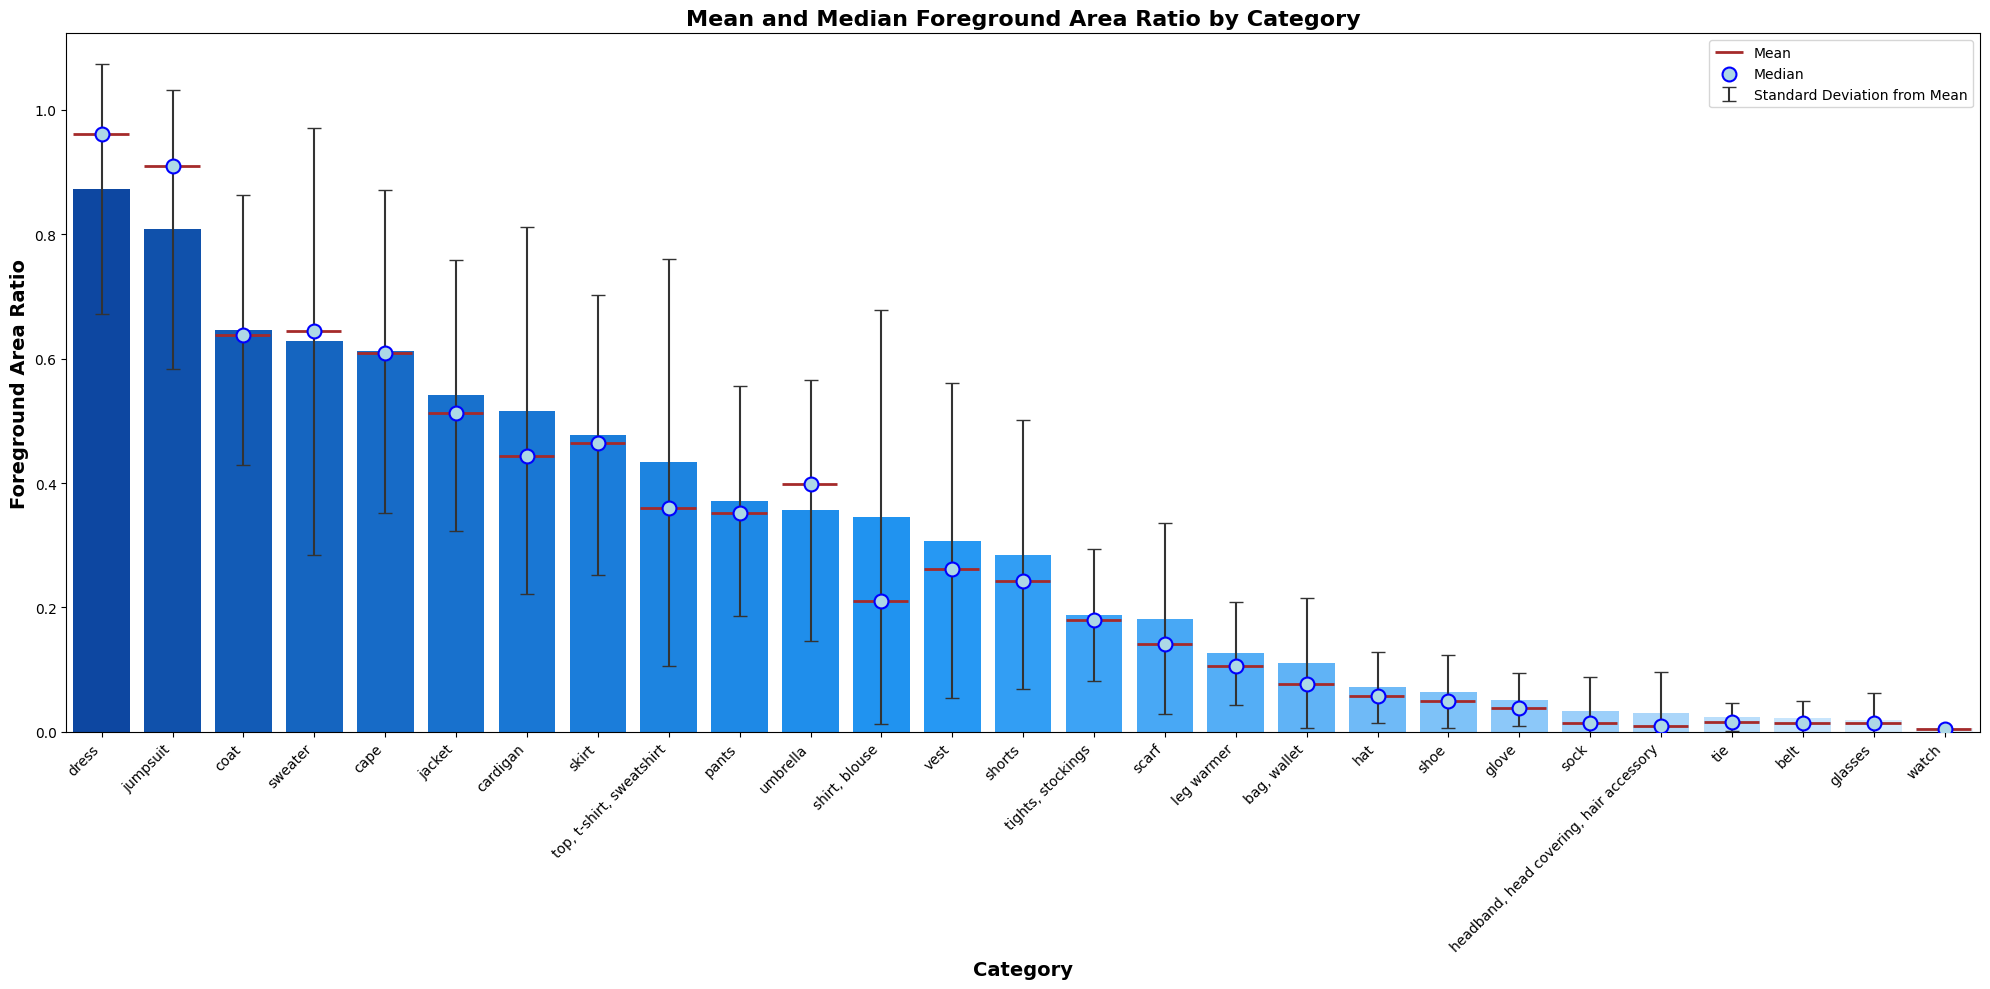

In [122]:
sorted_stats = ratio_df.sort_values(
    "foreground_area_ratio_mean", ascending=False
)

cmap = load_cmap("blue_material", cmap_type="continuous", reverse=True)

num_categories = len(sorted_stats)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

plt.figure(figsize=(20, 10))

bar_width = 0.8
x_positions = np.arange(len(sorted_stats))

plt.bar(x_positions, sorted_stats["foreground_area_ratio_mean"], color=colors, width=bar_width)

plt.errorbar(
    x_positions,
    sorted_stats["foreground_area_ratio_mean"],
    yerr=sorted_stats["foreground_area_ratio_stdev"],
    ecolor="#333333",
    capsize=5,
    fmt="none",
    label="Standard Deviation from Mean",
)

plt.hlines(
    y=sorted_stats["foreground_area_ratio_median"],
    xmin=x_positions - 0.4,
    xmax=x_positions + 0.38,
    colors="brown",
    linewidth=2,
    label="Mean",
    zorder=3,
)

plt.xticks(x_positions, sorted_stats["category_name"], rotation=45, ha="right")

plt.xlim(-0.5, len(sorted_stats) - 0.5)

plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Foreground Area Ratio", fontsize=14, fontweight="bold")
plt.title("Mean and Median Foreground Area Ratio by Category", fontsize=16, fontweight="bold")

plt.scatter(
    x_positions,
    sorted_stats["foreground_area_ratio_median"],
    marker="o",
    color="lightblue",
    edgecolor="blue",
    linewidth=1.5,
    s=100,
    zorder=4,
    label="Median",
)

upper_limit = (
    sorted_stats["foreground_area_ratio_mean"]
    + sorted_stats["foreground_area_ratio_stdev"]
).max() + 0.05
plt.ylim(0, upper_limit)

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_foreground_area_ratio.png")
plt.show()